In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import math
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
model_type = 'swmag'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [3]:
scalers = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		scalers[key] = {}
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl'):
				with open(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['swmag'] = scaler_values
					print(f'{key} scalers loaded')
		else:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl'):
				with open(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['swmag'] = scaler_values
					print(f'{key} scalers loaded')

CAN-0 scalers loaded
CAN-1 scalers loaded
CAN-2 scalers loaded
GRL-0 scalers loaded
GRL-1 scalers loaded
GRL-2 scalers loaded
GRL-3 scalers loaded
FSC-0 scalers loaded
FSC-1 scalers loaded
FSC-2 scalers loaded
FSC-3 scalers loaded
FSC-4 scalers loaded
FSC-5 scalers loaded
FSC-6 scalers loaded
CEU-0 scalers loaded
CEU-1 scalers loaded
CEU-2 scalers loaded
CEU-3 scalers loaded
SVLB scalers loaded
JPN-0 scalers loaded
JPN-1 scalers loaded
ALSK scalers loaded
HUD-0 scalers loaded
HUD-1 scalers loaded


In [4]:
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['twins_shap'] = shap_values
		else:
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['twins_shap'] = shap_values

In [5]:
other_model = 'twins'

for cluster in cluster_dict.values():
	for region in cluster['regions'].values():
		region['mean_lat'] = utils.getting_mean_lat(region['stations'])

# individual_cluster_to_examine = 'canadian_cluster'
swmag_mean_shap_twins, swmag_std_shap_twins, twins_mean_shap, twins_std_shap = [], [], [], []
dataframes_to_make = ['mean_shap_df', 'std_shap_df', 'transformed_X_df', 'mu_df', 'sigma_df', 'error_df']
twins_time_dict = {f'{feature}':{} for feature in shap_values['features']}

def inverse_transform_twins(X, mean, std):
	return X*std + mean

for feat in twins_time_dict.keys():
	for df in dataframes_to_make:
		twins_time_dict[feat][df] = pd.DataFrame()
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{other_model}_shap' in region.keys():

			# region[f'{other_model}_shap']['swmag_mean_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][0][0][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)
			# region[f'{other_model}_shap']['swmag_std_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][1][0][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)

			region[f'{other_model}_shap']['twins_mean_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][0][1][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)
			# region[f'{other_model}_shap']['twins_std_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][1][1][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)

			for key in region[f'{other_model}_shap'].keys():
				if isinstance(region[f'{other_model}_shap'][key], torch.Tensor):
					region[f'{other_model}_shap'][key] = region[f'{other_model}_shap'][key].numpy()

			# try:
			# region[f'{other_model}_shap']['swmag_mean_shap'] = region[f'{other_model}_shap']['swmag_mean_shap'].reshape(region[f'{other_model}_shap']['swmag_mean_shap'].shape[0], region[f'{other_model}_shap']['swmag_mean_shap'].shape[2], region[f'{other_model}_shap']['swmag_mean_shap'].shape[3])
			# region[f'{other_model}_shap']['swmag_std_shap'] = region[f'{other_model}_shap']['swmag_std_shap'].reshape(region[f'{other_model}_shap']['swmag_std_shap'].shape[0], region[f'{other_model}_shap']['swmag_std_shap'].shape[2], region[f'{other_model}_shap']['swmag_std_shap'].shape[3])

			region[f'{other_model}_shap']['twins_mean_shap'] = region[f'{other_model}_shap']['twins_mean_shap'].reshape(region[f'{other_model}_shap']['twins_mean_shap'].shape[0], region[f'{other_model}_shap']['twins_mean_shap'].shape[2], region[f'{other_model}_shap']['twins_mean_shap'].shape[3])

			region[f'{other_model}_shap']['testing_data'][1] = region[f'{other_model}_shap']['testing_data'][1].reshape(region[f'{other_model}_shap']['testing_data'][1].shape[0], region[f'{other_model}_shap']['testing_data'][1].shape[2], region[f'{other_model}_shap']['testing_data'][1].shape[3])
			# unscaling the testing_data
			mu = scalers[reg][other_model]['twins_mean']
			sigma = scalers[reg][other_model]['twins_std']
			region[f'{other_model}_shap']['testing_data'][1] = region[f'{other_model}_shap']['testing_data'][1]*sigma + mu
			
			# region[f'{other_model}_shap']['twins_std_shap'] = region[f'{other_model}_shap']['twins_std_shap'].reshape(region[f'{other_model}_shap']['twins_std_shap'].shape[0], region[f'{other_model}_shap']['twins_std_shap'].shape[2], region[f'{other_model}_shap']['twins_std_shap'].shape[3])

			# mean_added = np.sum(np.sum(np.abs(region[f'{other_model}_shap']['swmag_mean_shap']), axis=1),axis=1) + np.sum(np.sum(np.abs(region[f'{other_model}_shap']['twins_mean_shap']), axis=1),axis=1)
			mean_added = np.sum(np.sum(np.abs(region[f'{other_model}_shap']['twins_mean_shap']), axis=1), axis=1)
			print(mean_added.shape)
			# region[f'{other_model}_shap']['swmag_mean_shap'] = region[f'{other_model}_shap']['swmag_mean_shap']/mean_added[:,None,None]
			region[f'{other_model}_shap']['twins_mean_shap'] = region[f'{other_model}_shap']['twins_mean_shap']/mean_added[:,None,None]

			# std_added = np.sum(np.sum(np.abs(region[f'{other_model}_shap']['swmag_std_shap']), axis=1),axis=1) + np.sum(np.sum(np.abs(region[f'{other_model}_shap']['twins_std_shap']), axis=1),axis=1)
			# std_added = np.sum(np.sum(np.abs(region[f'{other_model}_shap']['twins_std_shap']), axis=1),axis=1)
			# region[f'{other_model}_shap']['swmag_std_shap'] = region[f'{other_model}_shap']['swmag_std_shap']/std_added[:,None,None]
			# region[f'{other_model}_shap']['twins_std_shap'] = region[f'{other_model}_shap']['twins_std_shap']/std_added[:,None,None]

			# swmag_mean_shap_twins.append(np.sum(region[f'{other_model}_shap']['swmag_mean_shap'], axis=1))
			# swmag_std_shap_twins.append(np.sum(region[f'{other_model}_shap']['swmag_std_shap'], axis=1))

			# twins_mean_shap.append(np.sum(np.sum(region[f'{other_model}_shap']['twins_mean_shap'], axis=1), axis=1))
			# twins_std_shap.append(np.sum(np.sum(region[f'{other_model}_shap']['twins_std_shap'], axis=1), axis=1))

			# del region[f'{other_model}_shap']['swmag_mean_shap'], region[f'{other_model}_shap']['swmag_std_shap'], region[f'{other_model}_shap']['twins_mean_shap'], region[f'{other_model}_shap']['twins_std_shap']
			# gc.collect()


# swmag_mean_shap_twins = np.concatenate(swmag_mean_shap_twins, axis=0)
# swmag_std_shap_twins = np.concatenate(swmag_std_shap_twins, axis=0)

# twins_mean_shap = np.concatenate(twins_mean_shap, axis=0)
# twins_std_shap = np.concatenate(twins_std_shap, axis=0)

# swmag_mean_shap_twins = np.mean(np.abs(swmag_mean_shap_twins), axis=0)
# swmag_std_shap_twins = np.mean(np.abs(swmag_std_shap_twins), axis=0)

# twins_mean_shap = np.mean(np.abs(twins_mean_shap), axis=0)
# twins_std_shap = np.mean(np.abs(twins_std_shap), axis=0)

# print(swmag_mean_shap_twins.shape)
# print(twins_mean_shap.shape)

# raise

# twins_mean_shap_df = pd.DataFrame(swmag_mean_shap_twins, columns=shap_values['features'])
# twins_std_shap_df = pd.DataFrame(swmag_std_shap_twins, columns=shap_values['features'])



Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [6]:
def mlt_wedge(img_data, mlt_min: int = 18, mlt_max: int = 6, center_x: int = 120, center_y: int = 80):
    """
    This function takes in a temperature ENA image and divides thems into pie slices based on the
    numbers of slices desired. The output of the function is an array of the mean different sections of the
    ENA temperature map generated and the different sections themselves, respectively.
    Parameters:
    -----------
    img_data : ndarray
        Input image data.
    mlt_min : int, optional
        Minimum MLT value. Default is 18.
    mlt_max : int, optional
        Maximum MLT value. Default is 6.
    mlt_span : int, optional
        MLT span. Default is 1.
    angle_steps : int, optional
        Number of angle steps for pie slices. Default is 8.
    center_x : int, optional
        X-coordinate of the center. Default is 120.
    center_y : int, optional
        Y-coordinate of the center. Default is 80.
    Returns:
    --------
    selected_sections : list
        List of selected pie slice sections.
    """
    # get the dimension of the image
    height, width = img_data.shape
    # Create an empty list to store the selected sections
    selected_sections = []
    img_mean = []
    # define the numbers of angles used for the pie slices
    # Create masks for each N-degree section and apply them to the image
    # Create a new blank mask as a NumPy array
    mask = np.zeros((height, width), dtype=np.uint8)
    img_copy = np.copy(img_data)
    # Calculate the coordinates of the sector's bounding box

    start_angle = (mlt_min*15) % 360
    end_angle = (mlt_max*15) % 360

    print(f'start_angle: {start_angle}, end_angle: {end_angle}')
    # Calculate the coordinates of the sector arc
    for y in range(height):
        for x in range(width):
            # Calculate the polar coordinates of the pixel relative to the image center
            dx = center_x - x
            dy = center_y - y
            pixel_angle = math.degrees(math.atan2(dy, dx))  # Calculate the angle in radians
            if pixel_angle < 0:
                pixel_angle += 360
            # Check if the pixel is within the current 45-degree section
            if mlt_min > mlt_max:
                if start_angle <= pixel_angle < 360 or 0 <= pixel_angle < end_angle:
                    mask[y, x] = 1
            else:
                if start_angle <= pixel_angle < end_angle:
                    mask[y, x] = 1  # Set the pixel to white (255)
    # Apply the mask to the heat map to select the section
    img_copy[mask == 0] = 0
    # Append the selected section to the list
    selected_sections = img_copy
    xx = np.copy(img_copy)
    xx[xx == 0] = np.nan
    # Get the mean of the non zero values of the image
    img_mean.append(np.nanmean(xx))
    print(f'mean: {np.nanmean(xx)}')
    return img_mean, selected_sections

In [7]:
key = '2012-03-07 01:50:00'
cluster = 'fennoscandinavian_cluster'
region = 'FSC-0'
cluster = 'canadian_cluster'
region = 'CAN-0'
# if region in list_of_oversampled_regions:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
# else:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
mlt_station = utils.loading_supermag(cluster_dict[cluster]['regions'][region]['mlt_station'])

Loading station NEW....


Index(['GEOLON', 'GEOLAT', 'MAGLON', 'MLAT', 'MLT', 'SZA', 'N', 'E', 'Z',
       'dbn_geo', 'dbe_geo', 'dbz_geo', 'MAGNITUDE', 'dbht', 'theta',
       'cos_theta', 'sin_theta'],
      dtype='object')
20.04
start_angle: 285.60001373291016, end_angle: 315.60001373291016
mean: -3.0719917861893365e-06
start_angle: 285.60001373291016, end_angle: 315.60001373291016
mean: 4.926123221831883


/tmp/ipykernel_459861/2026755674.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
/tmp/ipykernel_459861/2026755674.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]} - MLT: {mlt}", fontsize=20)


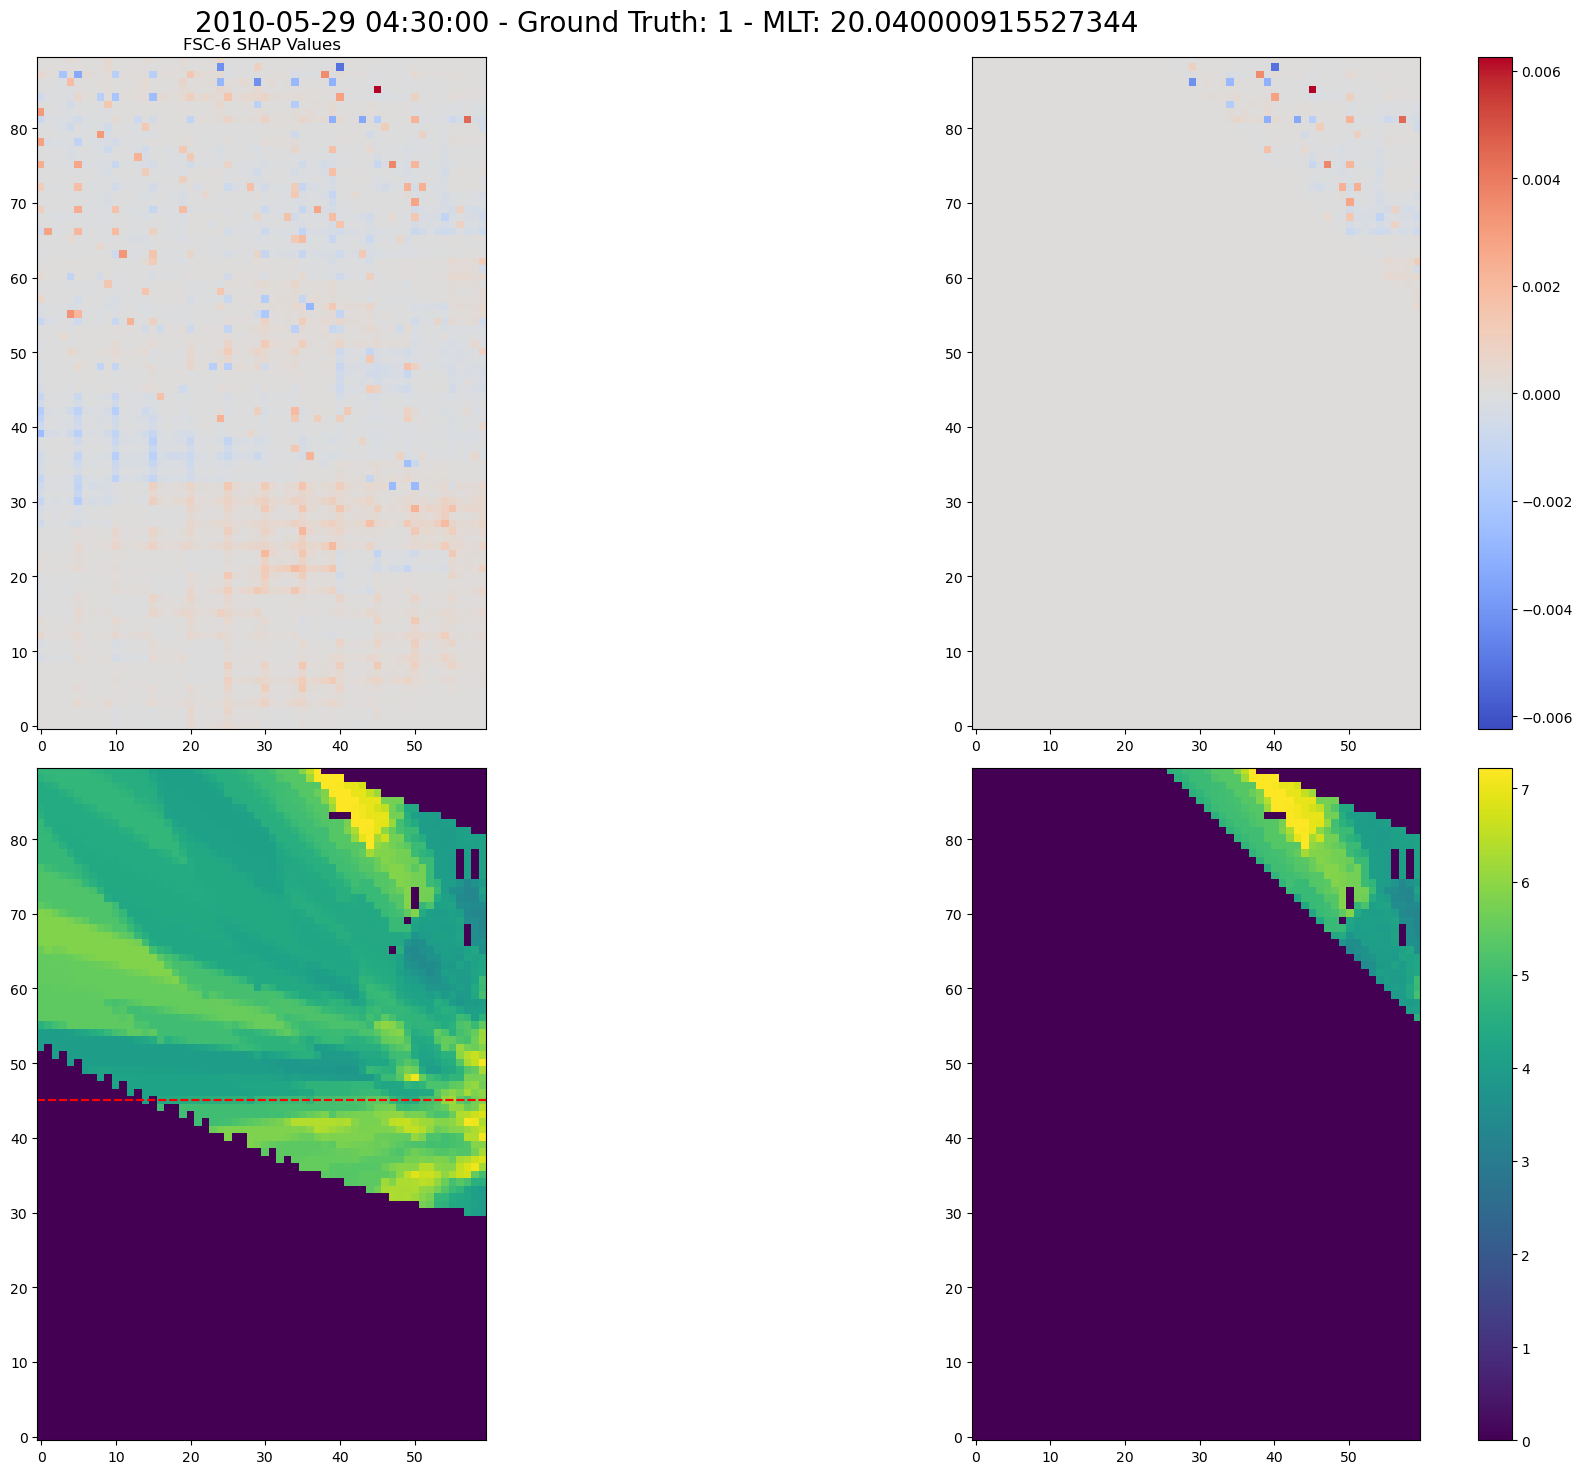

: 

In [28]:

print(mlt_station.columns)
i = 1560
mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
print(mlt)
mlt_min = mlt-1 if mlt >=1 else 24+mlt-1
mlt_max = mlt + 1 if mlt <= 23 else mlt - 24 + 1
full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]} - MLT: {mlt}", fontsize=20)
vmin = np.nanmin(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i])
vmax = np.nanmax(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i])
limit = np.max([np.abs(vmin), np.abs(vmax)])
ax[0,0].set_title(f'{region} SHAP Values')
im0 = ax[0,0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], cmap='coolwarm', vmin=-limit, vmax=limit, origin='lower')
ax[1,0].axhline(y=45, color='r', linestyle='--')
ax[0,1].imshow(full_selected_sections, cmap='coolwarm', vmin=-limit, vmax=limit, origin='lower')
fig.colorbar(im0, ax=ax[0,1])

vmax = np.nanmax(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i])
window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
im1 = ax[1,0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], origin='lower', vmin=0, vmax=vmax)
ax[1,0].axhline(y=45, color='r', linestyle='--')
im1 = ax[1,1].imshow(window_selected_sections, origin='lower', vmin=0, vmax=vmax)
fig.colorbar(im1, ax=ax[1,1])

# show plot with tight layout
plt.tight_layout()
plt.show()

[ 1191  1192  1193 ... 20236 20237 20238]


/tmp/ipykernel_459861/366620631.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]}", fontsize=20)


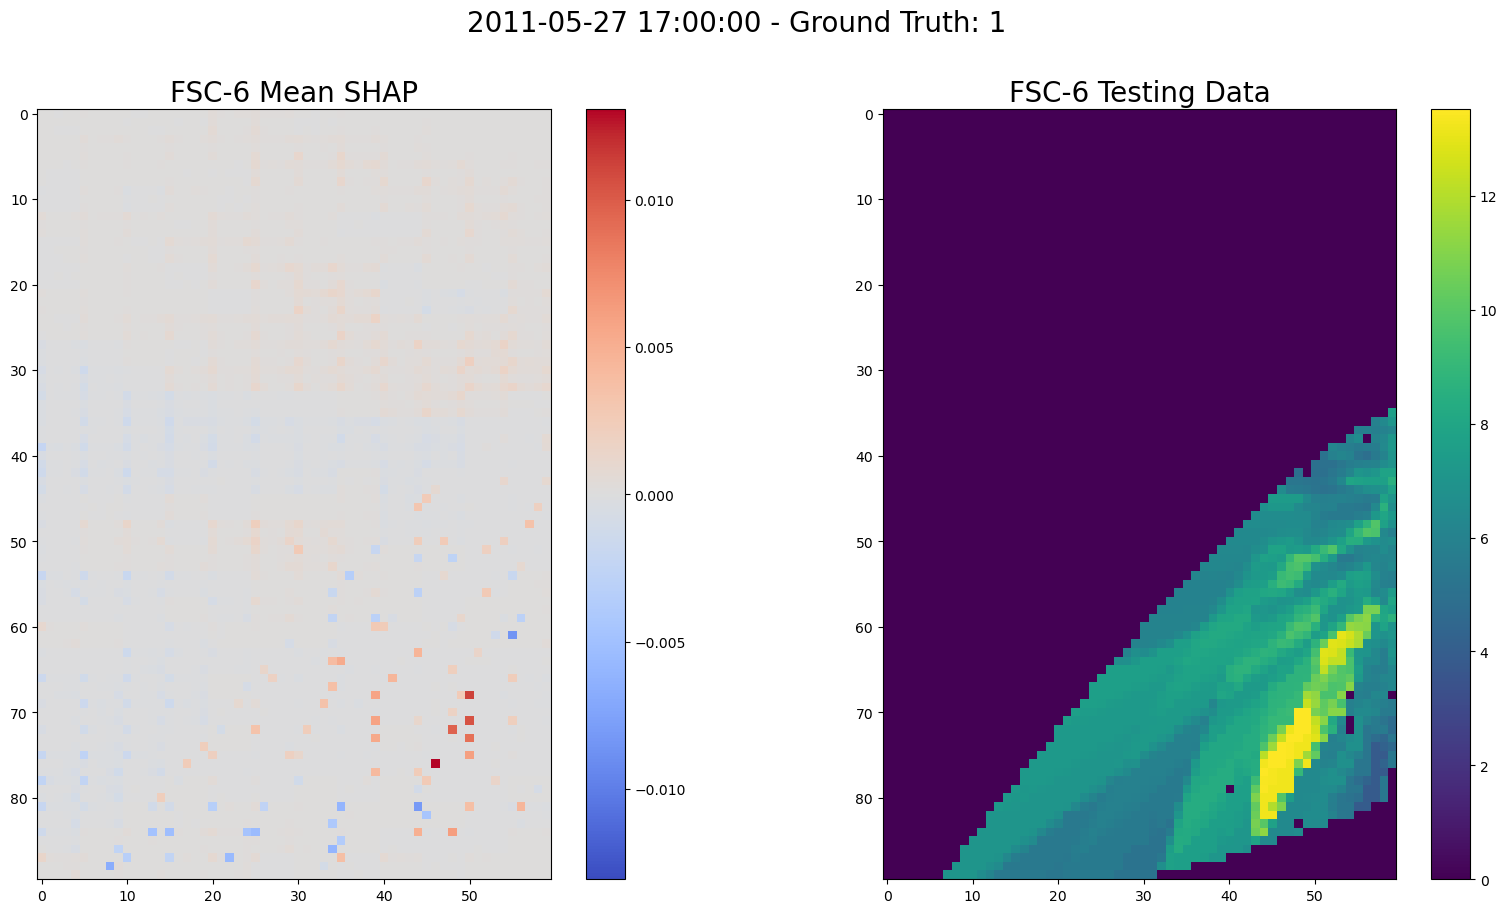

In [9]:
cluster = 'fennoscandinavian_cluster'
region = 'FSC-6'
# cluster = 'canadian_cluster'
# region = 'CAN-2'
positive_list = cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'] == 1
# getting True indicies
positive_list = np.where(positive_list)[0]
print(positive_list)
j=430
i = positive_list[j]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# doing imshow with colorbar
plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]}", fontsize=20)
extreme = np.max(np.abs(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i]))
im = axes[0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], cmap='coolwarm', vmin=-extreme, vmax=extreme)
fig.colorbar(im, ax=axes[0])
axes[0].set_title(f'{region} Mean SHAP', fontsize=20)

im = axes[1].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i])
fig.colorbar(im, ax=axes[1])
axes[1].set_title(f'{region} Testing Data', fontsize=20)

plt.show()